In [399]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from bucketing import Create4Buckets
from CTN import CN, CTN
from PvA import PvA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
url = 'https://raw.githubusercontent.com/BartoszSolka/MgrSpringApp/f41902605a7f5ea7f64e6e048db92cce137ca4bc/src/main/resources/england-premier-league-players-2018-to-2019-stats.csv'
df = pd.read_csv(url).dropna().reset_index(drop=True)

In [400]:
mp = df['minutes_played_overall']
s = df['goals_overall']
a = df['assists_overall']
app = df['appearances_overall']
ar = df['rank_in_league_top_attackers']
mr = df['rank_in_league_top_midfielders']
dr = df['rank_in_league_top_defenders']
min_buckets = Create4Buckets(mp,np.percentile(mp,90),np.percentile(mp,95),np.percentile(mp,99),"<90%","90-95%","95-99%","Top 1%","minute_buckets")
goal_buckets = Create4Buckets(s,np.percentile(s,90),np.percentile(s,95),np.percentile(s,99),"<90%","90-95%","95-99%","Top 1%","goal_buckets")
assist_buckets = Create4Buckets(a,np.percentile(a,90),np.percentile(a,95),np.percentile(a,99),"<90%","90-95%","95-99%","Top 1%","assist_buckets")
app_buckets = Create4Buckets(app,np.percentile(app,90),np.percentile(app,95),np.percentile(app,99),"<90%","90-95%","95-99%","Top 1%","app_buckets")

In [401]:
df2 = pd.concat([min_buckets,goal_buckets,assist_buckets,app_buckets],axis=1)
df = pd.concat([df,df2],axis=1)

In [402]:
pos = CN(df,"position")
nat = CN(df,"nationality")
club = CN(df,"Current Club")
gs = CN(df,"goal_buckets")
ast = CN(df,"assist_buckets")
apps = CN(df,"app_buckets")
clubs = CTN(df,5,6,club)
nationality = CTN(df,9,10,nat)
positions = CTN(df,4,5,pos)
goals = CTN(df,46,47,gs)
assists = CTN(df,47,48,ast)
appearances = CTN(df,48,49,apps)
X_num = df[['age', 'minutes_played_overall', 'minutes_played_home', 'minutes_played_away', 'appearances_overall', 'appearances_home', 'appearances_away', 'goals_overall', 'goals_home', 'goals_away', 'assists_overall', 'assists_home', 'assists_away', 'penalty_goals', 'penalty_misses', 'clean_sheets_overall', 'clean_sheets_home', 'clean_sheets_away', 'conceded_overall', 'conceded_home', 'conceded_away', 'yellow_cards_overall', 'red_cards_overall', 'goals_involved_per_90_overall', 'assists_per_90_overall', 'goals_per_90_overall', 'goals_per_90_home', 'goals_per_90_away', 'min_per_goal_overall', 'conceded_per_90_overall', 'min_per_conceded_overall', 'min_per_match', 'min_per_card_overall', 'min_per_assist_overall', 'cards_per_90_overall', 'rank_in_league_top_attackers', 'rank_in_league_top_midfielders', 'rank_in_league_top_defenders', 'rank_in_club_top_scorer']].reset_index(drop=True)
X_final = pd.concat([X_num, clubs, nationality, positions, goals, assists, appearances], axis=1)
y_final = df[['minute_buckets']].copy()
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.375, random_state=6)

In [403]:
models = []
models.append(('LR:', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA:', LinearDiscriminantAnalysis()))
models.append(('RFC:', RandomForestClassifier()))
models.append(('DTC:', DecisionTreeClassifier()))
models.append(('GNB:', GaussianNB()))
models.append(('BNB:', BernoulliNB()))
names = []
results = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=3, random_state=6, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring='accuracy')
    names.append(name)
    results.append(cv_results)
    print("%s %f (%f)" % (name, cv_results.mean(), cv_results.std()))

LR: 0.928745 (0.021826)
LDA: 0.924684 (0.010216)
RFC: 0.962342 (0.010209)
DTC: 0.974947 (0.010142)
GNB: 0.895411 (0.015489)
BNB: 0.849420 (0.036611)


In [404]:
model = DecisionTreeClassifier().fit(X_train, y_train.values.ravel())
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [405]:
print("Accuracy Score:", accuracy_score(y_test_pred, y_test))
print("Classification Report:", classification_report(y_test_pred, y_test))
print("Confusion Matrix:", confusion_matrix(y_test_pred, y_test))

Accuracy Score: 0.9930555555555556
Classification Report:               precision    recall  f1-score   support

      90-95%       1.00      1.00      1.00         8
      95-99%       0.80      1.00      0.89         4
        <90%       1.00      1.00      1.00       127
      Top 1%       1.00      0.80      0.89         5

    accuracy                           0.99       144
   macro avg       0.95      0.95      0.94       144
weighted avg       0.99      0.99      0.99       144

Confusion Matrix: [[  8   0   0   0]
 [  0   4   0   0]
 [  0   0 127   0]
 [  0   1   0   4]]


In [406]:
PvA = PvA(y_test_pred, y_test)

In [407]:
PvA[PvA.Predicted != PvA.Actual]

,Predicted,Actual
31,Top 1%,95-99%


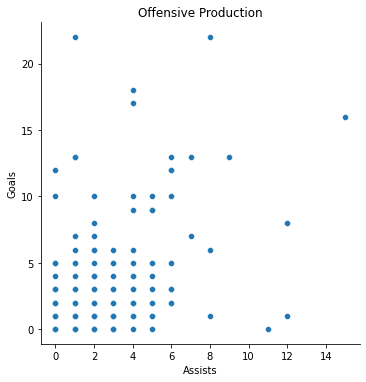

In [408]:
sns.relplot(data=df, x="assists_overall", y="goals_overall")
plt.title("Offensive Production")
plt.xlabel("Assists")
plt.ylabel("Goals")
plt.show()